In [111]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/../src')

wandb:   1 of 1 files downloaded.  


2025-04-26 14:05:23,837 - INFO - Downloaded artifact to /scratch/downloaded_artifacts/env_b6pz5pio:v2
{'ts': [3, 5], 'n_h': 32, 'n_in': 2, 'seed': {'data_seed': 43250, 'test_seed': 12345, 'parameter_seed': 39069}, 'n_out': 2, 'numTe': 5000, 'numTr': 500000, 'lossFn': 'cross_entropy', 'numVal': 2000, 'batch_tr': 1000, 'batch_vl': 1, 'tau_task': True, 'inner_clip': 1, 'outer_clip': 1, 'tr_avg_per': 20, 'vl_avg_per': 2000, 'architecture': 'rnn', 'activation_fn': 'tanh', 'inner_learner': 'bptt', 'log_influence': True, 'outer_learner': 'identity', 'inner_uoro_std': 1, 'log_to_float16': True, 'outer_uoro_std': 1, 'batch_or_online': 'batch', 'inner_optimizer': 'sgd', 'outer_optimizer': 'sgd', 'inner_log_special': False, 'num_retrain_loops': 100, 'outer_log_special': False, 'initialization_std': 1, 'checkpoint_interval': 51, 'inner_learning_rate': 0.020800842, 'inner_log_expensive': False, 'inner_time_constant': 1, 'outer_learning_rate': 0, 'outer_log_expensive': False, 'outer_time_constant': 

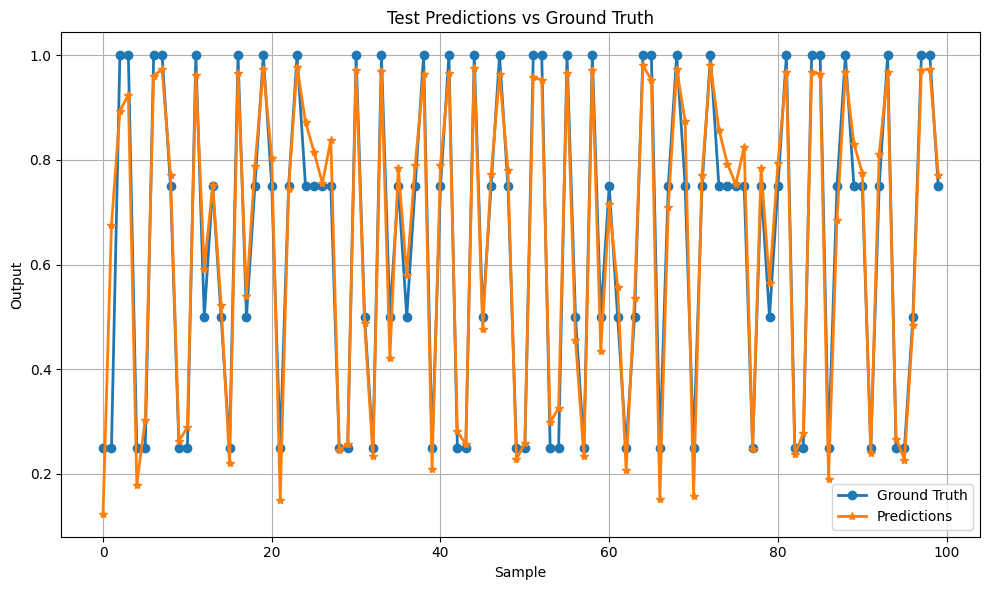

2025-04-26 14:05:25,804 - INFO - Plotted results.


In [112]:
# %%
import os
import sys
import logging
import pickle
import wandb
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np


# Import project modules
from dacite import from_dict, Config
from recurrent.myrecords import GodConfig
from recurrent.app import *



# %%
# --- Logging Setup ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler('download_and_validate.log')
    ]
)
logger = logging.getLogger(__name__)

# %%
# --- Configuration ---
artifact_path = 'wlp9800-new-york-university/oho_exps/env_3bgxgw2m:v2'
download_dir = "/scratch/downloaded_artifacts"
os.makedirs(download_dir, exist_ok=True)

# %%
# --- Download Artifact ---
api = wandb.Api()
artifact = api.artifact(artifact_path)
artifact_dir = os.path.join(download_dir, artifact.name)
artifact.download(root=artifact_dir)
logger.info(f"Downloaded artifact to {artifact_dir}")

# %%
# --- Load Config ---
run = artifact.logged_by()
print(run.config)
run.config["ffn_in"] = 0
run.config["ffn_layers"] = []
config = from_dict(
    data_class=GodConfig,
    data=run.config,
    config=Config(
                type_hooks={
                    tuple[int, int]: tuple,
                    tuple[tuple[int, Literal["tanh", "relu", "sigmoid", "identity", "softmax"]], ...]: lambda x: tuple(
                        map(tuple, x)
                    ),
                },
                strict=True,
            ),

            
)
logger.info("Config loaded successfully.")

# %%
# --- Load Saved Env from env.pkl ---
env_path = os.path.join(artifact_dir, "env.pkl")
with open(env_path, "rb") as f:
    saved_env = pickle.load(f)
logger.info("Loaded environment from env.pkl.")

# %%
# --- Create Interpreters ---
env_prng = PRNG(jax.random.key(config.seed.parameter_seed))
_, innerInterpreter, outerInterpreter = create_env(config, env_prng)
logger.info("Interpreters created.")

# %%
# --- Generate Test Dataset ---
test_prng = PRNG(jax.random.key(config.seed.test_seed))
te_dataset = adder_task(test_prng, config, config.ts, config.numTe, config.numTe)
logger.info(f"Generated test dataset with {len(te_dataset.value.value.x)} samples.")

template_env = create_env(config, env_prng)[0]
rec_param, _ = innerInterpreter.getRecurrentParam.func(innerInterpreter, saved_env)
_, saved_env = innerInterpreter.putRecurrentParam(rec_param).func(innerInterpreter, template_env)

# %%
# --- Build Model ---
lossFn = getLossFn(config)
innerLearner = create_learner(config.inner_learner, False, uoro_std=config.inner_uoro_std)
innerLibrary = create_rnn_learner(innerLearner, lossFn, config.architecture)

# Validation model that requires interpreter and env
validation_model = lambda ds: innerLibrary.model(ds).func
logger.info("Validation model created.")

# %%
# --- Predict on Test Dataset ---
predictions = []
ground_truth = []

te_dataset = tree_unstack(te_dataset)[0].value
print(te_dataset)

predictions, _ = validation_model(te_dataset)(innerInterpreter, saved_env)
predictions = [jax.nn.softmax(y)[0] for y in predictions.value][:100]
ground_truth = [y[0] for y in te_dataset.value.y][:100]
print(ground_truth)
# %%
# --- Plot Results ---
plt.figure(figsize=(10, 6))
plt.plot(ground_truth, "o-", label='Ground Truth', linewidth=2)

plt.plot(predictions, "*-", label='Predictions',linewidth=2)
plt.xlabel("Sample")
plt.ylabel("Output")
plt.title("Test Predictions vs Ground Truth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
logger.info("Plotted results.")